# <span style="color:#3498db">**A mini-tutorial**</span>

This codebook is a simple example meant to illustrate a two fundamental questions in time frequency analysis: 1) permutation-based null hypothesis testing and 2) correction for multiple comparisons. Typically, there is more than one approach for a given scenario. They will all depend on the dimensions of the data at hand, be these spatial locations, time and frequency analysis parameters, trials of different conditions, the nature of hypothesis, etc. For basic pedagogical purposes, here I focus on spectral power increases relative to baseline using two variants of the same method: 1) null hypothesis testing using the traditional min-max distribution approach, which captures variations at the extremes of the null ditribution, and 2) null hypthesis testing using the whole null distribution, obtained by averaging across specific dimensions. I invite the reader to audit the code and propvide feedback and comments in the open discussion subsection within the background section. Since there are several ways to achieve these goals and many realizations of these and other related methods (i.e. thresholds may be obtaind from the percentiles of the null distribution directly and further corrected in equivalent ways, or the pooling of data accomplished among specific dimensions), here I focus on two common methods using very simple examples in the hope to help those researchers (including myself) that are or may be in need of clarity on these matters, touch ground. Beware there may even be error to be spot or loops to optimize. 

Depending on the approach, the computation of the p-values will change slightly. In the min-max approach the minimum and maximum values at each permutations are used. When testing using the whole null distribution, the null values obtained from the permutations are averaged the same way the empirical distribution is averaged so the dimensions of the empirical distributions are preserved in the null distribution. Once the null distributions have been obtained, p-values are obtained using the empirical cumulative distribution method. Additionally, an optional step is illustrated in which cluster correction of the p-values is implemented. Provided the right Python environment is installed and data, this Jupyter notebook should work as a simple mini-tutorial and support the discussion of these and related basic approaches for computing TFRs and assessing their statistical significance in a clear way. The functions within this notebook are provided in an exploratory state and are subject to change. A background section with an open discussion subsection is included. Please feel free to use it help improve the codebook. The package can be downloaded from here: https://github.com/nicogravel/tfrStats


## Installl the package


To run the [notebook](https://github.com/nicogravel/tfrStats/blob/main/docs/html/notebooks/statistical_approach.ipynb), clone the package locally (optionally forking it first) and then install it:
  
    
```
git clone https://github.com/nicogravel/tfrStats.git

cd tfrStats

pip install -e .
```
  
    
    

Voilà!

## Import libraries and define functions

In [1]:
from tfrStats.plot_tfr_stats import plot_tfr_stats as plot_tfr_stats
from tfrStats.plot_dtfr_stats import plot_dtfr_stats as plot_dtfr_stats


in_path   = '/Volumes/Gandalf/MWlamprop/data/'
out_path  = '/Volumes/Gandalf/MWlamprop/results/stats/univariate/'

## Compute p-values

Here we plot TFRs with the significance threshold computed from p-values (i.e. p-val <= 0.05) (top panel, blue trace). The alpha mask specifies the section containing the values above the null percentile cutoff (i.e. 95%). The p-values (bottom panel) with the null percentile cutoff  (red trace)

### min-max

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_1000_minmax.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (1000, 30, 12, 16, 2)
min-max
cutoff computed using min/max of null distribution:  75.96054268486813


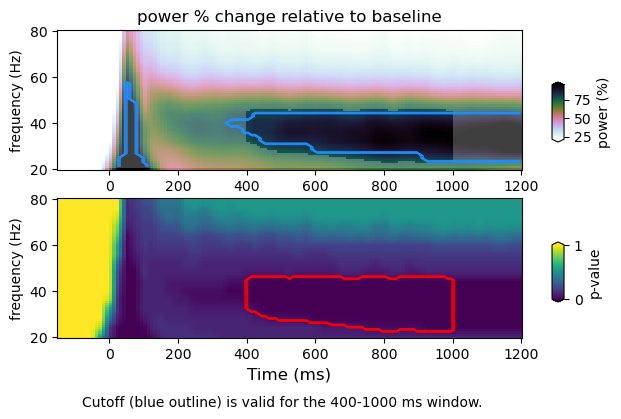

In [2]:
null         = [1, 95]
alpha        = 0.01
correction   = 1
cluster_size = 0
fband        = 1
cond         = 0
type         = 'minmax'

plot_tfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)  

### whole-null

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_100.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (30, 12, 16, 113)
whole-null
cutoff computed using whole null distribution:  70.79162686024465


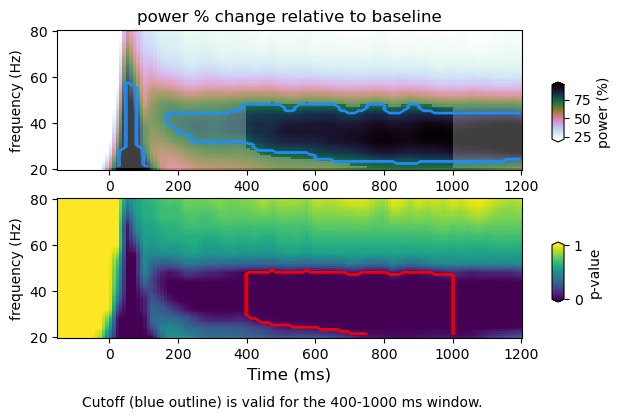

In [3]:
null         = [0, 95]
alpha        = 0.01
correction   = 1
cluster_size = 0
fband        = 1
cond         = 0
type         = 'whole'

plot_tfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)  

## Cluster correction of time-frequency bins


One can apply cluster correction either to the percetniles (using only this correction in a single step), or to the or pvalues (turning it into a second, optional step). Here we compute distances between all time-frequency bins, pool p-vals of neighbouring time-frequency bins based on a distance threshold (defined by cluster size), test if a time-frequency bin and its neighbours are below alpha, and —if true, average the p-values within the cluster and assign the resulting average as acorrected p-value to the time-frequency bin.

### min-max

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_1000_minmax.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (1000, 30, 12, 16, 2)
min-max
cutoff computed using min/max of null distribution:  75.96054268486813


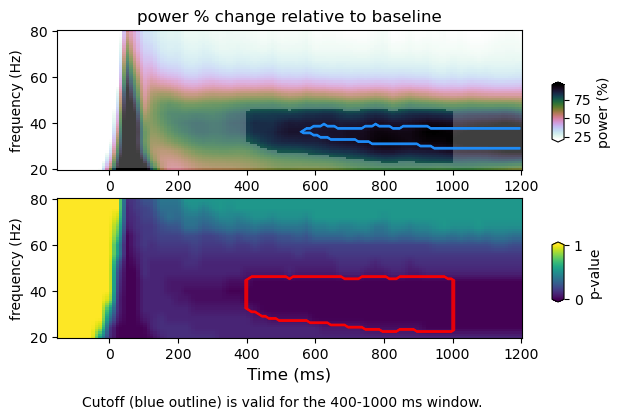

In [4]:
null         = [1, 95] 
alpha        = 0.01
correction   = 2
cluster_size = 3
fband        = 1
cond         = 0
type         = 'minmax'

plot_tfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)  

### whole-null

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_100.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (30, 12, 16, 113)
whole-null
cutoff computed using whole null distribution:  70.79162686024465


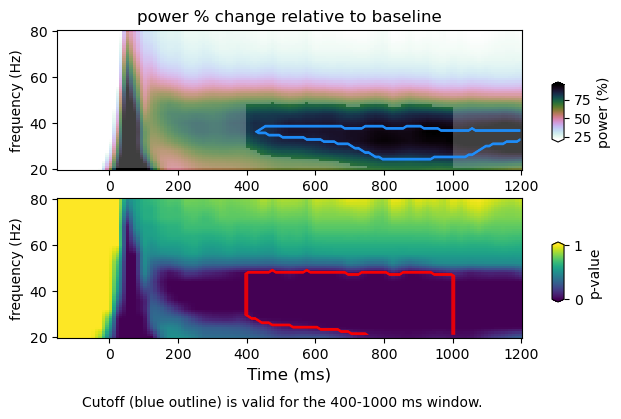

In [5]:
null         = [0, 95] 
alpha        = 0.01
correction   = 2
cluster_size = 3
fband        = 1
cond         = 0
type         = 'whole'

plot_tfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)  

##  Spectral power as a function of depth and space

For this other type of TFR one must consider the pooling of data over predefined frequency bins, as well as spatial dimentions (i.e.  ROIs). Therefore, the multiple correction will change slightly. 

### min-max

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_1000_minmax.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (1000, 30, 12, 16, 2)
peak frequency range :  28.0 44.0
power average within peak: 86.6390137791448
min-max
cutoff computed using min/max of null distribution:  70.91082666125475


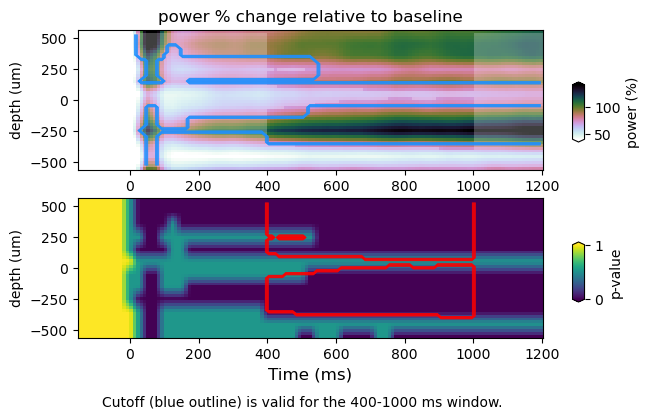

In [6]:
null         = [1, 95]
alpha        = 0.05
correction   = 1
cluster_size = 0
fband        = 1
cond         = 0
type         = 'minmax'

plot_dtfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)

###  whole null

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_100.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (30, 12, 16, 113)
peak frequency range :  28.0 44.0
power average within peak: 86.6390137791448
whole-null
cutoff computed using whole null distribution:  70.52901730660238


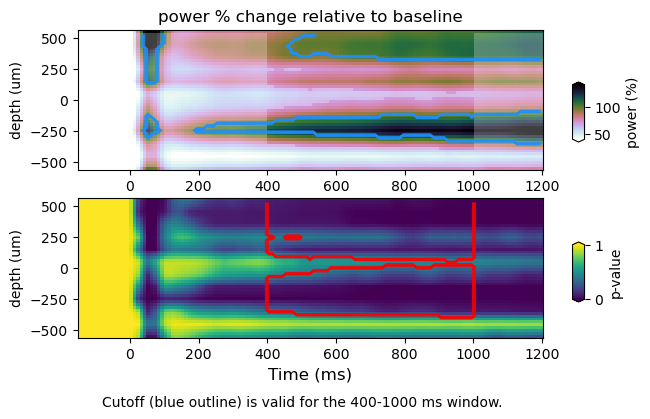

In [7]:
null         = [0, 95] 
alpha        = 0.05
correction   = 1
cluster_size = 0
fband        = 1
cond         = 0
type         = 'whole'

plot_dtfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)  

## Cluster correction of space-frequency bins


One can apply cluster correction either to the percetniles (using only this correction in a single step), or to the or pvalues (turning it into a second, optional step). Here we compute distances between all space-frequency bins, pool p-vals of neighbouring space-frequency bins based on a distance threshold (defined by cluster size), test if a space-frequency bin and its neighbours are below alpha, and —if true, average the p-values within the cluster and assign the resulting average as acorrected p-value to the space-frequency bin.

### min-max

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_1000_minmax.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (1000, 30, 12, 16, 2)
peak frequency range :  28.0 44.0
power average within peak: 86.6390137791448
min-max
cutoff computed using min/max of null distribution:  70.91082666125475


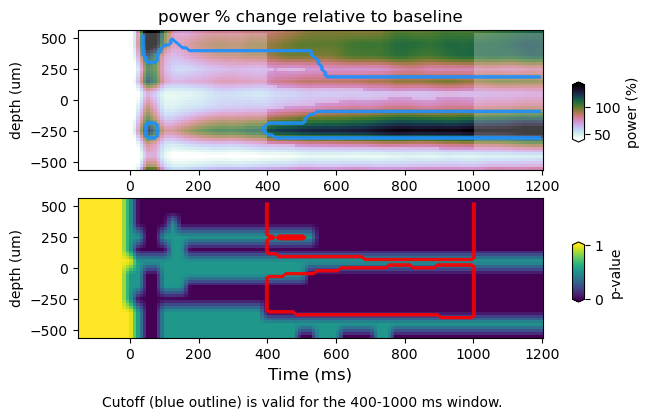

In [8]:
null         = [1, 95] 
alpha        = 0.05
correction   = 2
cluster_size = 1
fband        = 1
cond         = 0
type         = 'minmax'

plot_dtfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha)  

### whole-null

/Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_100.npz
tfr emp  :  (30, 12, 16, 113)
tfr null    (30, 12, 16, 113)
peak frequency range :  28.0 44.0
power average within peak: 86.6390137791448
whole-null
cutoff computed using whole null distribution:  70.52901730660238


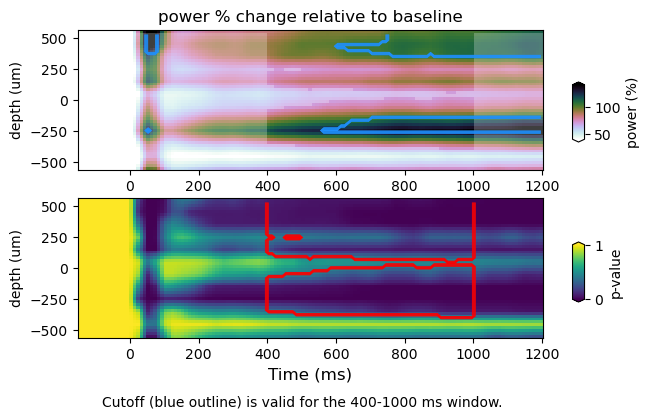

In [9]:
null         = [0, 95] 
alpha        = 0.05
correction   = 2
cluster_size = 1
fband        = 1
cond         = 0
type         = 'whole'

plot_dtfr_stats(out_path, cond, fband, null, correction, cluster_size, type, alpha) 